In [3]:
import pandas as pd
import numpy as np
from FPSim2.io import create_db_file
from FPSim2 import FPSim2Engine
import scipy
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy.cluster.hierarchy as sch


In [4]:

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS

In [5]:
%pylab inline
%config InlineBackend.figure_format =   'svg'

# CT colors: blue x 3, gray x 3, pink x 3
# Shades and Tints from https://www.colorhexa.com/da6388
CT_cols = ['#4a79a5', '#93b4d2', '#e6edf4',
           '#848688', '#b5b6b7', '#f2f2f2'
           '#da6388', '#eaa9be', '#f4d2dd' ]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

In [7]:
from matplotlib.colors import LinearSegmentedColormap
cma = get_continuous_cmap([CT_cols[0], CT_cols[7]])

# Read // Write

In [10]:
dfile = "../data/raw/train.csv"

In [8]:
smi_file = "../data/derived/train.smi"
h5_file = '../data/derived/train.h5'
# id_output = "C2_compounds.ID.txt"
# ccccccc = "C2_compounds.txt"

In [11]:
df = pd.read_csv(dfile, index_col=0)
# df_smi = df.loc[df['is full']==1, "product"]

# df_dataf = df.loc[df['is full']==1, ["product", "enrichment(20062_C1_E2)"]]

# df_smi.to_csv("C2_compounds_.smi", sep="\t", header = False)
# df_dataf.to_csv(exp_dataf)

In [13]:
# df

then in bash: `obabel -xc -ismi C2_compounds.smi -osmi -O C2_compounds.xc.smi`


In [14]:
smiles = []
ind_names = []
smiles_dict = {}
with open(smi_file, 'r') as iFile:
    for i, s in enumerate(iFile):
        S = s.strip().split()
        smiles.append([S[0], i])
        ind_names.append(S[1])
        smiles_dict[S[1]] = S[0]

In [15]:
create_db_file(smiles, h5_file, 'Morgan',
               {'radius': 2, 'nBits': 2048})

In [21]:
# with open(id_output, 'w') as iFile:
#     for i in ind_names:
#         iFile.write(i + "\n")
#     iFile.write("\n")

In [22]:
# df = pd.read_csv(exp_dataf, index_col=0)

In [ ]:
# # Checking that distance matrix is 1- sim. That is so
# ac = []
# for i, s in enumerate(list(smiles_dict)):
#     if s in id_a:
#         ac.append([smiles_dict[s], i])
# #         print(i,s )
# create_db_file(ac, "tmp.h5", 'Morgan',
#                {'radius': 2, 'nBits': 2048})   
# fp_filename = "tmp.h5"
# fpe = FPSim2Engine(fp_filename)
# query = 'CNC(=O)c1cc(NC(=O)CN2CC2)cc(c1)c1cccnc1'
# results = fpe.similarity(query, 0.0, n_workers=1)
# results

# Calc distances

In [16]:
fp_filename = h5_file
fpe = FPSim2Engine(fp_filename)
ids = fpe.fps[:, 0]

In [17]:
ind_names = np.array(ind_names)
ind_names_res = ind_names[ids]

In [ ]:
csr_matrix = fpe.symmetric_distance_matrix(0.0, n_workers=12)

  0%|          | 128/70711 [00:07<46:33, 25.27it/s]  

In [ ]:
dense_matrix = csr_matrix.todense()

In [27]:
# a = dense_matrix[5:760, 5:760]
# id_a = ind_names_res[5:760]

In [ ]:
dense_matrix.shape

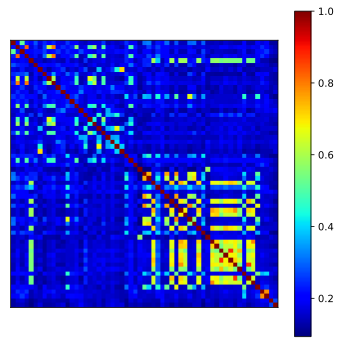

In [29]:
fig, ax = plt.subplots(figsize=(6,6))
# ax = fig.add_axes()

im = ax.imshow(1 - dense_matrix, cmap='jet')
fig.colorbar(im)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig("sum_mat.svg")




## Clustering

In [30]:
# convert the redundant n*n square matrix form into a condensed nC2 array
distArray = ssd.squareform(dense_matrix)

In [35]:

clustering = DBSCAN(min_samples=3, eps=0.3, metric='precomputed')
clustering.fit(dense_matrix)
labels = clustering.labels_


In [36]:
N = labels.max()
print(N)

2


In [37]:
np.sum(labels != -1)

23

In [38]:
with open("clustering_by_sim.txt", "w") as iFile:
    for i in np.unique(labels):
        for l in ind_names_res[labels == i]:
            s = smiles_dict[l]
            iFile.write(s + "\t" + l + "\t" + str(i) + "\n")
    

In [ ]:
## Select the best compounds